In [94]:
import torch
import numpy as np
from utils.generate_csbm import *
from utils.utils import *
from utils.train_helpers import train_NC, train_APPNP, train_pyg_model
from utils.utils import calculate_Atilde
from models.models import MLP
from models.setup import set_up_NC
import networkx as nx
import pickle
import matplotlib.pyplot as plt

In [95]:
final_seeds = [101993, 124709, 196252,  95930,  68222, 101539,  22989,  45367,
       166831, 189085,  12237, 242044,  40182,  84405, 234468, 233451,
       154898,  81745,  70716,  39777, 248183, 109371, 112311, 229323,
         2160, 219137, 221729,  98972, 238056, 265088,  90081, 271232,
       260735,  96076, 121375,  11447]
final_cc_ids = [1, 0, 2, 3, 2, 1, 2, 1, 2, 2, 0, 1, 1, 2, 0, 1, 2, 1, 2, 1, 3, 0,
       0, 0, 1, 2, 1, 0, 1, 1, 0, 0, 3, 0, 0, 1]

dataset = Planetoid(root='/tmp/Cora', name='Cora')
cora_data = dataset[0]
G, Xs, ys, A = pygdata_to_frameformat(cora_data)

def generate_subcora(rs, ith_cc, 
                     G, cora_data, Xs, ys, A, 
                     subgraph_size = 300):
    torch.manual_seed(rs)
    ids = torch.randperm(cora_data.y.shape[0]).numpy()
    sub_ids = ids[0:800]
    subcora = G.subgraph(ids[0:800])
    connected_components = sorted(nx.connected_components(subcora), key=len, reverse=True)
    train_nodes = np.array(list(connected_components[ith_cc]))
    all_reachable_nodes = []
    for train_node in train_nodes:
        for reachable_node in nx.bfs_tree(G,source=train_node, depth_limit=2):
            all_reachable_nodes.append(reachable_node)
    avail_nodes = np.array(list(set(all_reachable_nodes) - set(train_nodes)))
    num_train = len(train_nodes)
    num_val = num_train
    val_nodes = avail_nodes[:num_train]
    test_nodes = avail_nodes[num_train:subgraph_size-num_train]
    all_ids = np.concatenate([train_nodes,val_nodes,test_nodes], axis=0)
    
    sub_Xs = Xs[all_ids]
    sub_ys = ys[all_ids]
    sub_A = A[all_ids,][:,all_ids]
    
    train_mask = np.arange(num_train)
    val_mask = np.arange(num_train, num_train+num_val)
    test_mask = np.arange(num_train+num_val,subgraph_size)
    
    X = sub_Xs.view(subgraph_size, -1)
    y = sub_ys.view(subgraph_size)

    edge_index = []
    N = sub_A.shape[0]
    for i in range(N):
        for j in range(N):
            if (i != j):
                if (sub_A[i,j] == 1):
                    edge_index.append([i,j])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    subcora_data = Data(x=X, y=y, edge_index=edge_index, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
    
    
    return subcora_data, sub_Xs, sub_ys, sub_A, calculate_Atilde(sub_A, 10, 0.9), train_mask, val_mask, test_mask

In [96]:
seed_idx=0
subcora_data, sub_Xs, sub_ys, sub_A, sub_Atilde, train_ids, val_ids, test_ids = generate_subcora(final_seeds[seed_idx],
                                                                                                 final_cc_ids[seed_idx],
                                                                                                 G,
                                                                                                 cora_data, 
                                                                                                 Xs, ys, 
                                                                                                 A,
                                                                                                 subgraph_size=300)

In [97]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, APPNP
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx, from_scipy_sparse_matrix
import networkx as nx
from scipy import sparse
import torch.optim as optim
import torch.nn.functional as F
class appnp(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, hidden_dimensions=64, bias=False,
                 K=10, alpha=0.1):
        super().__init__()
        self.appnp_layer = APPNP(K=K, alpha=alpha, cached=True)
        self.linear = nn.Linear(num_node_features, hidden_dimensions, bias=bias)
        self.output = nn.Linear(hidden_dimensions, num_classes, bias=bias)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.linear(x)
        x = F.relu(x)
        x = self.output(self.appnp_layer(x, edge_index))
        return F.log_softmax(x, dim=1) 

In [110]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = appnp(1433, 7, bias=True).to(device)
data = subcora_data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
tl = []
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    tl.append(loss.item())
    optimizer.step()

In [111]:
model.eval()
_, pred = model(data).max(dim=1)
correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / int(data.test_mask.shape[0])
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.6034


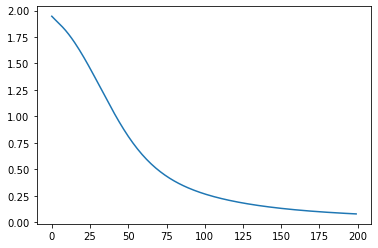

In [112]:
plt.plot(tl)

In [125]:
from torch_geometric.utils import from_scipy_sparse_matrix
import scipy
import torch

edge_index = from_scipy_sparse_matrix(sparse.csr_matrix(A))[0]
data = Data(x=X, y=y, edge_index=edge_index, train_mask=train_ids, valid_mask=valid_mask, test_mask=test_ids)

NameError: name 'X' is not defined

In [1]:
import torch
import numpy as np
from utils.utils import *
from utils.train_helpers import *
from models.models import *
from models.setup import *
import networkx as nx
import pickle
 
import copy
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from os.path import exists
import argparse
import os

from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx

final_seeds = [101993, 124709, 196252,  95930,  68222, 101539,  22989,  45367,
       166831, 189085,  12237, 242044,  40182,  84405, 234468, 233451,
       154898,  81745,  70716,  39777, 248183, 109371, 112311, 229323,
         2160, 219137, 221729,  98972, 238056, 265088,  90081, 271232,
       260735,  96076, 121375,  11447]
final_cc_ids = [1, 0, 2, 3, 2, 1, 2, 1, 2, 2, 0, 1, 1, 2, 0, 1, 2, 1, 2, 1, 3, 0,
       0, 0, 1, 2, 1, 0, 1, 1, 0, 0, 3, 0, 0, 1]

dataset = Planetoid(root='/tmp/Cora', name='Cora')
cora_data = dataset[0]
G, Xs, ys, A = pygdata_to_frameformat(cora_data)

def generate_subcora(rs, ith_cc, 
                     G, cora_data, Xs, ys, A, 
                     subgraph_size = 300):
    torch.manual_seed(rs)
    ids = torch.randperm(cora_data.y.shape[0]).numpy()
    sub_ids = ids[0:800]
    subcora = G.subgraph(ids[0:800])
    connected_components = sorted(nx.connected_components(subcora), key=len, reverse=True)
    train_nodes = np.array(list(connected_components[ith_cc]))
    all_reachable_nodes = []
    for train_node in train_nodes:
        for reachable_node in nx.bfs_tree(G,source=train_node, depth_limit=2):
            all_reachable_nodes.append(reachable_node)
    avail_nodes = np.array(list(set(all_reachable_nodes) - set(train_nodes)))
    num_train = len(train_nodes)
    num_val = num_train
    val_nodes = avail_nodes[:num_train]
    test_nodes = avail_nodes[num_train:subgraph_size-num_train]
    all_ids = np.concatenate([train_nodes,val_nodes,test_nodes], axis=0)
    
    sub_Xs = Xs[all_ids]
    sub_ys = ys[all_ids]
    sub_A = A[all_ids,][:,all_ids]
    
    train_mask = np.arange(num_train)
    val_mask = np.arange(num_train, num_train+num_val)
    test_mask = np.arange(num_train+num_val,subgraph_size)
    
    X = sub_Xs.view(subgraph_size, -1)
    y = sub_ys.view(subgraph_size)

    edge_index = []
    N = sub_A.shape[0]
    for i in range(N):
        for j in range(N):
            if (i != j):
                if (sub_A[i,j] == 1):
                    edge_index.append([i,j])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    subcora_data = Data(x=X, y=y, edge_index=edge_index, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
    
    
    return subcora_data, sub_Xs, sub_ys, sub_A, calculate_Atilde(sub_A, 10, 0.9), train_mask, val_mask, test_mask





subcora_data, sub_Xs, sub_ys, sub_A, sub_Atilde, train_ids, val_ids, test_ids = generate_subcora(final_seeds[0],
                                                                                                 final_cc_ids[0],
                                                                                                 G,
                                                                                                 cora_data, 
                                                                                                 Xs, ys, 
                                                                                                 A,
                                                                                                 subgraph_size=300)
torch.manual_seed(0)
init_mlp = MLP(sub_Xs[0].shape[1], 64, 7, bias=False)

server = set_up_NC(sub_Xs, sub_ys, init_mlp, sub_Atilde, 
                   train_ids, val_ids, test_ids,
                   True,
                   False, False,
                   0.01, 0.01)

tl, ta, vl, va = train_NC(server, 200, 1, 0.01, 10, True, 5)

D:\Anaconda\envs\datascience\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Mingxuan Zhang\Desktop\GFL-APPNP\utils\utils.py:57: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = np.array(adjacency_matrix(G).todense())


Communication: 5 Average train loss: 1.91644 Average train accuracy: 0.412 Average val loss: 1.94300 Average val accuracy: 0.206
Communication: 10 Average train loss: 1.88347 Average train accuracy: 0.618 Average val loss: 1.93731 Average val accuracy: 0.206
Communication: 15 Average train loss: 1.84249 Average train accuracy: 0.794 Average val loss: 1.92880 Average val accuracy: 0.294
Communication: 20 Average train loss: 1.78959 Average train accuracy: 0.824 Average val loss: 1.91626 Average val accuracy: 0.353
Communication: 25 Average train loss: 1.72376 Average train accuracy: 0.794 Average val loss: 1.89869 Average val accuracy: 0.412
Communication: 30 Average train loss: 1.64444 Average train accuracy: 0.794 Average val loss: 1.87648 Average val accuracy: 0.382
Communication: 35 Average train loss: 1.55270 Average train accuracy: 0.794 Average val loss: 1.85101 Average val accuracy: 0.382
Communication: 40 Average train loss: 1.45286 Average train accuracy: 0.824 Average val los

KeyboardInterrupt: 